# Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [102]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile

In [36]:
fs = 44100

In [171]:
FIG_WIDTH = 8
H_XLIM = [0.1, 20e3]
H_YLIM = [-50, 10]

def plot_frequency_response(b, a):
    f, H = signal.freqz(b, a)
    f *= fs/2/pi
    fig, ax = subplots(1, 1, figsize=[FIG_WIDTH, 4])
    ax.semilogx(f, 20*log10(abs(H)))
    ax.grid(True)
    ax.set_xlim(*H_XLIM)
    ax.set_ylim(*H_YLIM)

def prbs_analyze(x, y, fs, h_length):
    # Estimate impulse response using a pseudo-random bit sequence.
    h = signal.correlate(y, x, "full")
    h = h[len(h)//2:]
    
    # Limit the impulse response length to lower the noise
    h = h[0:h_length]
    t = arange(h_length)/fs

    # Estimate frequency response
    H = fft.fft(h)
    H = H[0:len(H)//2] 
    H /= max(abs(H))
    f = linspace(0.01, fs/2, len(H))
    
    # Show results
    fig, (ax1, ax2) = subplots(2, 1, figsize=[8, 8])
    
    ax1.semilogx(f, 20*log10(abs(H)))
    ax1.grid(True)
    ax1.set_xlim(*H_XLIM)
    ax1.set_ylim(*H_YLIM)
    
    ax2.plot(t, real(h))

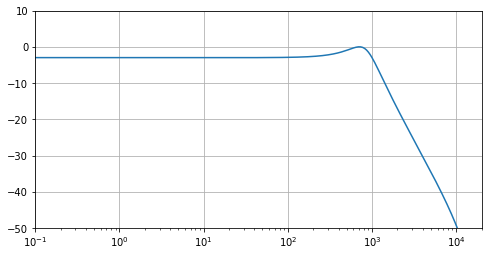

In [172]:
# Example filter
b, a = signal.cheby1(2, 3, 1000 * 2/fs, btype="low")
plot_frequency_response(b, a)

# Zavalishin 2015 The Art of VA Filter Design

Single-pole filter

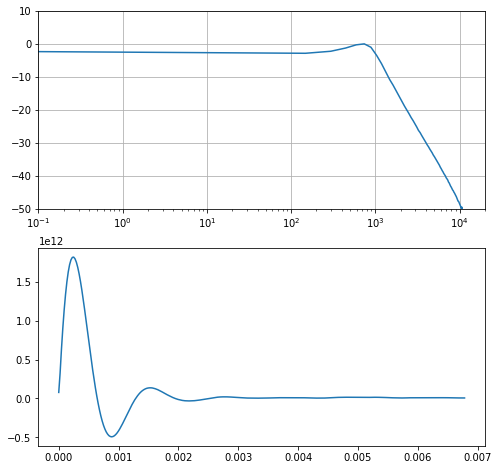

In [173]:
fs, x = scipy.io.wavfile.read("../app/sound/prbs15.wav")
y = signal.lfilter(b, a, x)
prbs_analyze(x, y, fs, 300)

## ST AN3984 - IIR filter design equations for Sound Terminal devices

Not successful.

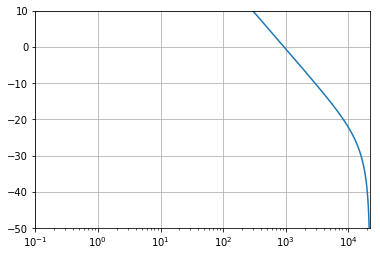

In [100]:
fc = 1000
Q = 2

wc = 2*pi*fc/fs
K = tan(wc/2)
alpha = 1+K

a = [0]*2
b = [0]*2

a[0] = 1
a[1] = -(1 + K)/alpha

b[0] = K/alpha
b[1] = K/alpha

plot_frequency_response(b, a)